In [2]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from dbc.utils import compute_class_conditional_risk_with_labels


def make_preprocessor(X):
    num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features)
        ]
    )
    return preprocessor


def global_risk(y_true, y_pred):
    return np.mean(y_true != y_pred)


def max_gap(y_true, y_pred):
    R = compute_class_conditional_risk_with_labels(y_true, y_pred)[0]
    return np.max(R) - np.min(R)


def variances_Rk(y_true, y_pred):
    R = compute_class_conditional_risk_with_labels(y_true, y_pred)[0]
    return np.var(R)


def max_Rk(y_true, y_pred):
    R = compute_class_conditional_risk_with_labels(y_true, y_pred)[0]
    return np.max(R)


In [133]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

# df = fetch_ucirepo(id=17)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=15)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=53)  # IRIS
# df = fetch_ucirepo(id=186)  # Wine quality
# df = fetch_ucirepo(id=2)  # Adult
# df = fetch_ucirepo(id=222)  # Bank Marketing
# df = fetch_ucirepo(id=19)  # Car Evaluation(表现很差)
# df = fetch_ucirepo(id=73)  # Mushroom

# SPDMC参数似乎是越大越好70 1.4，没测试更高的
# df = fetch_ucirepo(id=59)  # Letter Recognition(不知道为什么这个数据集DMC和SPDMC效果很差,难道是分类类别过多导致的？)
df = fetch_ucirepo(id=149)  # Statlog (Vehicle Silhouettes)(如果SPDMC不收敛记得移除类别只有1个的)

X = df.data.features.replace("?", np.nan)  # Only for adult

X = df.data.features
X = make_preprocessor(X).fit_transform(X)
y = df.data.targets.values.ravel()

# Onlu for Statlog
mask = y != '204'
X = X.iloc[mask] if hasattr(X, 'iloc') else X[mask]
y = y[mask]

y = LabelEncoder().fit_transform(y)
np.bincount(y)

array([217, 212, 217, 199])

In [142]:
from dbc.main import CmeansDiscreteBayesianClassifier, CmeansDiscreteMinmaxClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
# Initialize the C-means Discrete Bayesian Classifier with 10 clusters
# Set the fuzzifier to 1.5 and use the cluster centers from the DBC_kmeans classifier
# base_model = CmeansDiscreteBayesianClassifier(n_clusters=400, fuzzifier=1.3, use_kmeans=True)
base_model = CmeansDiscreteMinmaxClassifier(n_clusters=400, fuzzifier=1.3, use_kmeans=True, max_iter=300)

# Fit the classifier using the training data
base_model.fit(X_train, y_train)


# Predict the labels for the training data
y_pred = base_model.predict(X_train)

# Compute and return the conditional risk based on the true labels and predicted labels
conditional_risk = compute_class_conditional_risk_with_labels(y_train, y_pred)
print(f'Train Class condition risk: {conditional_risk[0]}')
# print(f'\nConfusion matrix: \n{conditional_risk[1]}')
print(f'Train Global risk: {global_risk(y_train, y_pred)}')

# Predict the labels for the training data
y_pred = base_model.predict(X_test)

# Compute and return the conditional risk based on the true labels and predicted labels
conditional_risk = compute_class_conditional_risk_with_labels(y_test, y_pred)
print(f'Test Class condition risk: {conditional_risk[0]}')
# print(f'\nConfusion matrix: \n{conditional_risk[1]}')
print(f'Test Global risk: {global_risk(y_test, y_pred)}')

Train Class condition risk: [0.15606936 0.14705882 0.14942529 0.1509434 ]
Train Global risk: 0.15088757396449703
Test Class condition risk: [0.70454545 0.61904762 0.39534884 0.775     ]
Test Global risk: 0.621301775147929


In [110]:

# base_model.prior_star

array([0.29839247, 0.2220655 , 0.32936673, 0.1501753 ])

In [136]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import make_scorer

scoring = {
    "global_risk": make_scorer(global_risk, greater_is_better=False),
    "max_Rk": make_scorer(max_Rk, greater_is_better=False),
    "max_gap": make_scorer(max_gap, greater_is_better=False),
    "variances_Rk": make_scorer(variances_Rk, greater_is_better=False),
}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)


def print_results(results):
    print("Train global_risk: %.3f (± %.3f)" %
          (-results["train_global_risk"].mean(), results["train_global_risk"].std()))
    print("Train max_Rk: %.3f (± %.3f)" %
          (-results["train_max_Rk"].mean(), results["train_max_Rk"].std()))
    print("Train max_gap: %.3f (± %.3f)" %
          (-results["train_max_gap"].mean(), results["train_max_gap"].std()))
    print("Train variances_Rk: %.3f (± %.3f)" %
          (-results["train_variances_Rk"].mean(), results["train_variances_Rk"].std()))

    print("Test global_risk: %.3f (± %.3f)" %
          (-results["test_global_risk"].mean(), results["test_global_risk"].std()))
    print("Test max_Rk: %.3f (± %.3f)" %
          (-results["test_max_Rk"].mean(), results["test_max_Rk"].std()))
    print("Test max_gap: %.3f (± %.3f)" %
          (-results["test_max_gap"].mean(), results["test_max_gap"].std()))
    print("Test variances_Rk: %.3f (± %.3f)" %
          (-results["test_variances_Rk"].mean(), results["test_variances_Rk"].std()))

In [ ]:
# # Repeat 10 experiments comparing KmeansDiscreteBayesianClassifier and KmeansDiscreteMinimaxClassifier
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from dbc.main import KmeansDiscreteMinmaxClassifier, KmeansDiscreteBayesianClassifier
# from dbc.utils import compute_conditional_risk
#
# # Experimental parameters
# n_experiments = 10
# results_dmc_per_class = []  # DMC results
# results_dbc_per_class = []  # DBC results
# n_classes = len(np.unique(y))
#
# # Repeat experiments 10 times
# for i in range(n_experiments):
#     print(f"Running experiment {i + 1}/{n_experiments}...")
#
#     # Use different random seeds for data splitting in each experiment
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42 + i, stratify=y
#     )
#
#     # DMC model
#     dmc_model = KmeansDiscreteMinmaxClassifier(n_clusters=200, random_state=42)
#     dmc_model.fit(X_train, y_train)
#     y_test_pred_dmc = dmc_model.predict(X_test)
#     conditional_risk_dmc = compute_conditional_risk(y_test, y_test_pred_dmc)[0]
#     results_dmc_per_class.append(conditional_risk_dmc)
#
#     # DBC model
#     dbc_model = KmeansDiscreteBayesianClassifier(n_clusters=200, random_state=42)
#     dbc_model.fit(X_train, y_train)
#     y_test_pred_dbc = dbc_model.predict(X_test)
#     conditional_risk_dbc = compute_conditional_risk(y_test, y_test_pred_dbc)[0]
#     results_dbc_per_class.append(conditional_risk_dbc)
#
# # Convert to numpy arrays
# results_dmc_per_class = np.array(results_dmc_per_class)  # shape: (10, n_classes)
# results_dbc_per_class = np.array(results_dbc_per_class)  # shape: (10, n_classes)
#
# # Create comparative boxplots
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#
# # DMC boxplot
# box_plot_dmc = axes[0].boxplot(results_dmc_per_class, labels=[f'Class {i}' for i in range(n_classes)],
#                                patch_artist=True, showmeans=True)
# colors_dmc = ['lightcoral', 'lightsalmon', 'lightpink', 'mistyrose', 'lavenderblush',
#               'lightsteelblue', 'lightcyan', 'lightblue', 'lightgray', 'lightgoldenrodyellow']
# for patch, color in zip(box_plot_dmc['boxes'], colors_dmc[:n_classes]):
#     patch.set_facecolor(color)
#
# axes[0].set_xlabel('Class')
# axes[0].set_ylabel('Conditional Risk')
# axes[0].set_title('KmeansDiscreteMinimaxClassifier (DMC)')
# axes[0].grid(True, alpha=0.3)
#
# # DBC boxplot
# box_plot_dbc = axes[1].boxplot(results_dbc_per_class, labels=[f'Class {i}' for i in range(n_classes)],
#                                patch_artist=True, showmeans=True)
# colors_dbc = ['lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcyan',
#               'lightpink', 'lightsalmon', 'lightsteelblue', 'lightcoral', 'lightgoldenrodyellow']
# for patch, color in zip(box_plot_dbc['boxes'], colors_dbc[:n_classes]):
#     patch.set_facecolor(color)
#
# axes[1].set_xlabel('Class')
# axes[1].set_ylabel('Conditional Risk')
# axes[1].set_title('KmeansDiscreteBayesianClassifier (DBC)')
# axes[1].grid(True, alpha=0.3)
#
# plt.suptitle(f'DMC vs DBC Conditional Risk Distribution Comparison\nDataset: {df["metadata"]["name"]}, 10 Experiments',
#              fontsize=14)
# plt.tight_layout()
# plt.show()
#
# # Create side-by-side comparison boxplot
# fig, ax = plt.subplots(figsize=(14, 8))
#
# # Prepare data for side-by-side display
# positions_dmc = np.arange(n_classes) * 3 + 1  # DMC positions
# positions_dbc = np.arange(n_classes) * 3 + 2  # DBC positions
#
# # Draw DMC boxplots
# bp_dmc = ax.boxplot(results_dmc_per_class, positions=positions_dmc, widths=0.6,
#                     patch_artist=True, showmeans=True,
#                     boxprops=dict(facecolor='lightcoral', alpha=0.7),
#                     medianprops=dict(color='red', linewidth=2),
#                     meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='darkred', markersize=6))
#
# # Draw DBC boxplots
# bp_dbc = ax.boxplot(results_dbc_per_class, positions=positions_dbc, widths=0.6,
#                     patch_artist=True, showmeans=True,
#                     boxprops=dict(facecolor='lightblue', alpha=0.7),
#                     medianprops=dict(color='blue', linewidth=2),
#                     meanprops=dict(marker='D', markerfacecolor='blue', markeredgecolor='darkblue', markersize=6))
#
# # Set x-axis labels
# ax.set_xticks(np.arange(n_classes) * 3 + 1.5)
# ax.set_xticklabels([f'Class {i}' for i in range(n_classes)])
# ax.set_xlabel('Class')
# ax.set_ylabel('Conditional Risk')
# ax.set_title(f'DMC vs DBC Conditional Risk Comparison\nDataset: {df["metadata"]["name"]}, {n_experiments} Experiments')
#
# # Add legend
# from matplotlib.patches import Patch
#
# legend_elements = [Patch(facecolor='lightcoral', alpha=0.7, label='DMC (Minimax)'),
#                    Patch(facecolor='lightblue', alpha=0.7, label='DBC (Bayesian)')]
# ax.legend(handles=legend_elements, loc='upper right')
#
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()
#
# # Detailed statistical analysis
# print("\n=== DMC vs DBC Conditional Risk Statistical Comparison ===")
# print(f"Number of experiments: {n_experiments}")
# print(f"Number of classes: {n_classes}")
# print("=" * 70)
#
# for i in range(n_classes):
#     dmc_values = results_dmc_per_class[:, i]
#     dbc_values = results_dbc_per_class[:, i]
#
#     print(f"\nClass {i}:")
#     print("-" * 50)
#     print(f"{'Metric':<15} {'DMC (Minimax)':<15} {'DBC (Bayesian)':<15} {'Difference (DMC-DBC)':<15}")
#     print("-" * 65)
#     print(
#         f"{'Mean':<15} {np.mean(dmc_values):<15.6f} {np.mean(dbc_values):<15.6f} {np.mean(dmc_values) - np.mean(dbc_values):<15.6f}")
#     print(
#         f"{'Std Dev':<15} {np.std(dmc_values):<15.6f} {np.std(dbc_values):<15.6f} {np.std(dmc_values) - np.std(dbc_values):<15.6f}")
#     print(
#         f"{'Median':<15} {np.median(dmc_values):<15.6f} {np.median(dbc_values):<15.6f} {np.median(dmc_values) - np.median(dbc_values):<15.6f}")
#     print(
#         f"{'Min':<15} {np.min(dmc_values):<15.6f} {np.min(dbc_values):<15.6f} {np.min(dmc_values) - np.min(dbc_values):<15.6f}")
#     print(
#         f"{'Max':<15} {np.max(dmc_values):<15.6f} {np.max(dbc_values):<15.6f} {np.max(dmc_values) - np.max(dbc_values):<15.6f}")
#
# # Overall performance comparison
# print("\n=== Overall Performance Comparison ===")
# print("-" * 50)
#
# # Average risk per class
# dmc_mean_risks = np.mean(results_dmc_per_class, axis=0)
# dbc_mean_risks = np.mean(results_dbc_per_class, axis=0)
#
# print(f"DMC average risk per class: {dmc_mean_risks}")
# print(f"DBC average risk per class: {dbc_mean_risks}")
#
# # Maximum risk gap (Max Gap)
# dmc_max_gaps = np.max(results_dmc_per_class, axis=1) - np.min(results_dmc_per_class, axis=1)
# dbc_max_gaps = np.max(results_dbc_per_class, axis=1) - np.min(results_dbc_per_class, axis=1)
#
# print(f"\nDMC maximum risk gap: mean={np.mean(dmc_max_gaps):.6f}, std={np.std(dmc_max_gaps):.6f}")
# print(f"DBC maximum risk gap: mean={np.mean(dbc_max_gaps):.6f}, std={np.std(dbc_max_gaps):.6f}")
# print(f"Risk gap improvement: {np.mean(dbc_max_gaps) - np.mean(dmc_max_gaps):.6f} (negative means DMC is better)")
#
# # Global risk
# dmc_global_risks = np.mean(results_dmc_per_class, axis=1)
# dbc_global_risks = np.mean(results_dbc_per_class, axis=1)
#
# print(f"\nDMC global risk: mean={np.mean(dmc_global_risks):.6f}, std={np.std(dmc_global_risks):.6f}")
# print(f"DBC global risk: mean={np.mean(dbc_global_risks):.6f}, std={np.std(dbc_global_risks):.6f}")
# print(
#     f"Global risk improvement: {np.mean(dbc_global_risks) - np.mean(dmc_global_risks):.6f} (negative means DMC is better)")

In [62]:
from sklearn.model_selection import cross_validate
from dbc.main import KmeansDiscreteMinmaxClassifier

from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    # 'n_clusters': [10, 20, 30, 40, 50, 60, 70],
    'n_clusters': [200],
}

# 创建基础模型
base_model = KmeansDiscreteMinmaxClassifier()

# 创建网格搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring={"max_gap": make_scorer(max_gap, greater_is_better=False)},  # 使用你定义的scoring
    cv=rskf,  # 使用你的交叉验证策略
    n_jobs=-1,  # 使用所有CPU核心
    verbose=1,  # 显示进度
    refit='max_gap',
)

# 执行搜索
grid_search.fit(X, y)

# 获取最佳参数和结果
print("最佳参数:")
print(grid_search.best_params_)
print("\n最佳分数:")
print(grid_search.best_score_)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_
results_DMC = cross_validate(
    best_model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
print('DMC results:')
print_results(results_DMC)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
最佳参数:
{'n_clusters': 200}

最佳分数:
-0.34816125734730385
DMC results:
Train global_risk: 0.245 (± 0.012)
Train max_Rk: 0.356 (± 0.029)
Train max_gap: 0.192 (± 0.046)
Train variances_Rk: 0.005 (± 0.002)
Test global_risk: 0.382 (± 0.044)
Test max_Rk: 0.547 (± 0.070)
Test max_gap: 0.315 (± 0.082)
Test variances_Rk: 0.015 (± 0.006)


In [63]:
from sklearn.model_selection import GridSearchCV
from dbc.main import CmeansDiscreteMinmaxClassifier

# 定义参数网格
param_grid = {
    # 'n_clusters': [20, 30, 40, 50, 60, 70],
    'n_clusters': [200],
    'fuzzifier': [1.1],
    # 'fuzzifier': [1.01,1.02,1.03,1.04, 1.05, 1.1],
    'use_kmeans': [True]
}

# 创建基础模型
base_model = CmeansDiscreteMinmaxClassifier()

# 创建网格搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring={"max_gap": make_scorer(max_gap, greater_is_better=False)},  # 使用你定义的scoring
    cv=rskf,  # 使用你的交叉验证策略
    n_jobs=-1,  # 使用所有CPU核心
    verbose=1,  # 显示进度
    refit='max_gap',
)

# 执行搜索
grid_search.fit(X, y)

# 获取最佳参数和结果
print("最佳参数:")
print(grid_search.best_params_)
print("\n最佳分数:")
print(grid_search.best_score_)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_
results_SPDMC = cross_validate(
    best_model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
print('SPDMC results:')
print_results(results_SPDMC)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
最佳参数:
{'fuzzifier': 1.1, 'n_clusters': 200, 'use_kmeans': True}

最佳分数:
-0.20610594831525067
SPDMC results:
Train global_risk: 0.265 (± 0.021)
Train max_Rk: 0.284 (± 0.020)
Train max_gap: 0.038 (± 0.026)
Train variances_Rk: 0.000 (± 0.000)
Test global_risk: 0.450 (± 0.046)
Test max_Rk: 0.546 (± 0.084)
Test max_gap: 0.232 (± 0.096)
Test variances_Rk: 0.010 (± 0.006)


In [151]:
# from dbc.main import DiscriminativeMinmaxClassifier
# model = DiscriminativeMinmaxClassifier(n_clusters=40, n_epochs=100, kl_regularization=0.1)
# results_DNN_SPDMC = cross_validate(
#     model,
#     X, y,
#     cv=rskf,
#     scoring=scoring,
#     return_train_score=True,
#     n_jobs=-1,
# )
# print('DNN_SPDMC results:')
# print_results(results_DNN_SPDMC)

In [152]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# 创建基础模型
base_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# 创建网格搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring={"max_gap": make_scorer(max_gap, greater_is_better=False)},  # 使用你定义的scoring
    cv=rskf,  # 使用你的交叉验证策略
    n_jobs=-1,  # 使用所有CPU核心
    verbose=1,  # 显示进度
    refit='max_gap',
)

# 执行搜索
grid_search.fit(X, y)

# 获取最佳参数和结果
print("最佳参数:")
print(grid_search.best_params_)
print("\n最佳分数:")
print(grid_search.best_score_)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_
results_WLR = cross_validate(
    best_model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
print('WLR results:')
print_results(results_WLR)

Fitting 100 folds for each of 6 candidates, totalling 600 fits
最佳参数:
{'C': 100, 'penalty': 'l2'}

最佳分数:
-0.37439755786848805
WLR results:
Train global_risk: 0.162 (± 0.007)
Train max_Rk: 0.311 (± 0.016)
Train max_gap: 0.298 (± 0.016)
Train variances_Rk: 0.021 (± 0.002)
Test global_risk: 0.195 (± 0.028)
Test max_Rk: 0.394 (± 0.059)
Test max_gap: 0.374 (± 0.061)
Test variances_Rk: 0.027 (± 0.009)


In [128]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 35, ],
}

# 创建基础模型
base_model = DecisionTreeClassifier(class_weight='balanced')

# 创建网格搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring={"max_gap": make_scorer(max_gap, greater_is_better=False)},  # 使用你定义的scoring
    cv=rskf,  # 使用你的交叉验证策略
    n_jobs=-1,  # 使用所有CPU核心
    verbose=1,  # 显示进度
    refit='max_gap',
)

# 执行搜索
grid_search.fit(X, y)

# 获取最佳参数和结果
print("最佳参数:")
print(grid_search.best_params_)
print("\n最佳分数:")
print(grid_search.best_score_)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_
results_WDT = cross_validate(
    best_model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
print('WDT results:')
print_results(results_WDT)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
最佳参数:
{'max_depth': 14}

最佳分数:
-0.13259085412195457
WDT results:
Train global_risk: -0.000 (± 0.000)
Train max_Rk: -0.000 (± 0.000)
Train max_gap: -0.000 (± 0.000)
Train variances_Rk: -0.000 (± 0.000)
Test global_risk: 0.035 (± 0.005)
Test max_Rk: 0.166 (± 0.080)
Test max_gap: 0.163 (± 0.083)
Test variances_Rk: 0.006 (± 0.005)


In [132]:
best_model.tree_.n_leaves

np.int64(133)

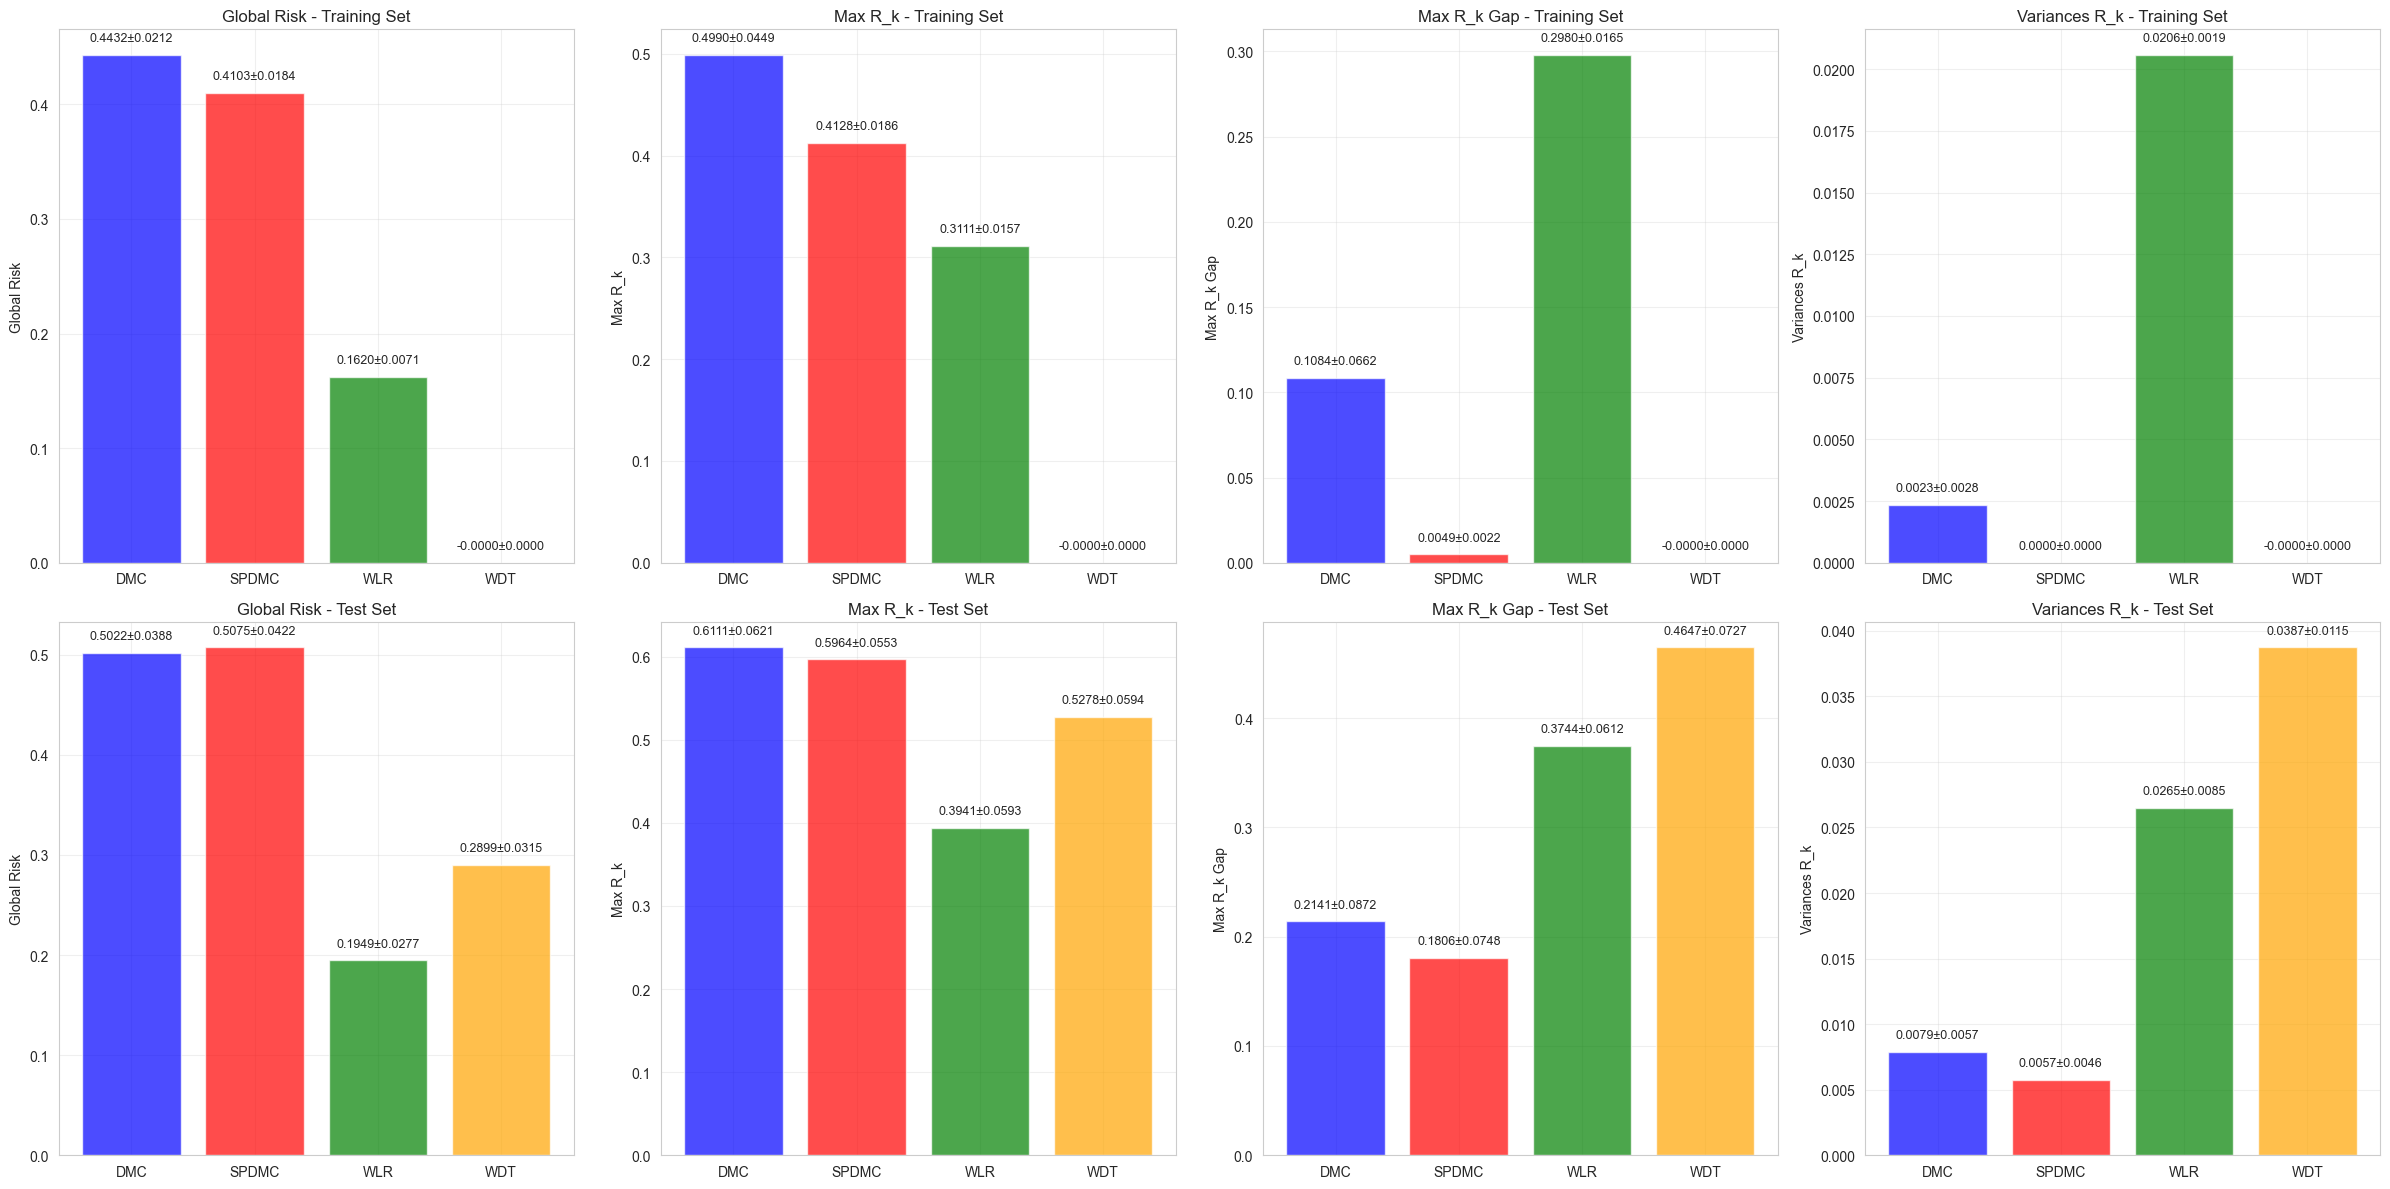

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# 收集所有结果
results_dict = {
    'DMC': results_DMC,
    'SPDMC': results_SPDMC,
    'WLR': results_WLR,
    'WDT': results_WDT
}

# 定义指标和标签
metrics = ['global_risk', 'max_Rk', 'max_gap', 'variances_Rk']
metric_labels = ['Global Risk', 'Max R_k', 'Max R_k Gap', 'Variances R_k']

# 创建子图
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

# 为每个指标创建训练集和测试集的对比图
for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    # 训练集结果
    ax_train = axes[i]
    train_means = [-results_dict[model][f'train_{metric}'].mean() for model in results_dict.keys()]
    train_stds = [results_dict[model][f'train_{metric}'].std() for model in results_dict.keys()]

    bars = ax_train.bar(results_dict.keys(), train_means,
                        capsize=5, alpha=0.7, color=['blue', 'red', 'green', 'orange', 'grey'])
    ax_train.set_title(f'{label} - Training Set')
    ax_train.set_ylabel(label)
    ax_train.grid(True, alpha=0.3)

    # 添加数值标签 - 修复：只基于柱子高度，不使用std
    y_min, y_max = ax_train.get_ylim()
    y_range = y_max - y_min

    for bar, mean, std in zip(bars, train_means, train_stds):
        height = bar.get_height()

        # 根据y轴范围自适应偏移量
        adaptive_offset = y_range * 0.02  # y轴范围的3%

        # 标签位置 - 移除 std
        if height >= 0:
            label_y = height + adaptive_offset
        else:  # 处理负值情况
            label_y = height - adaptive_offset

        ax_train.text(bar.get_x() + bar.get_width() / 2., label_y,
                      f'{mean:.4f}±{std:.4f}', ha='center',
                      va='bottom' if height >= 0 else 'top', fontsize=9)

    # 测试集结果 - 同样修复
    ax_test = axes[i + 4]
    test_means = [-results_dict[model][f'test_{metric}'].mean() for model in results_dict.keys()]
    test_stds = [results_dict[model][f'test_{metric}'].std() for model in results_dict.keys()]

    bars = ax_test.bar(results_dict.keys(), test_means,
                       capsize=5, alpha=0.7, color=['blue', 'red', 'green', 'orange', 'grey'])
    ax_test.set_title(f'{label} - Test Set')
    ax_test.set_ylabel(label)
    ax_test.grid(True, alpha=0.3)

    # 添加数值标签 - 修复：只基于柱子高度
    y_min, y_max = ax_test.get_ylim()
    y_range = y_max - y_min

    for bar, mean, std in zip(bars, test_means, test_stds):
        height = bar.get_height()

        # 根据y轴范围自适应偏移量
        adaptive_offset = y_range * 0.02  # y轴范围的3%

        # 标签位置 - 移除 std
        if height >= 0:
            label_y = height + adaptive_offset
        else:  # 处理负值情况
            label_y = height - adaptive_offset

        ax_test.text(bar.get_x() + bar.get_width() / 2., label_y,
                     f'{mean:.4f}±{std:.4f}', ha='center',
                     va='bottom' if height >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig(f"./figure/{df['metadata']['name']}.pdf", bbox_inches='tight')

In [218]:
# 该单元格为运行一次实验所需
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from dbc.main import KmeansDiscreteMinmaxClassifier, CmeansDiscreteMinmaxClassifier
from dbc import compute_class_conditional_risk_with_labels

T = 40
fuzzifier = 2

# ---------------------------------------------------------------------------
DMC = KmeansDiscreteMinmaxClassifier(n_clusters=T)
DMC.fit(X_train, y_train)

y_pred_DMC_test = DMC.predict(X_test)
risks_DMC_test = compute_class_conditional_risk_with_labels(y_test, y_pred_DMC_test)[0]
y_pred_DMC_train = DMC.predict(X_train)
risks_DMC_train = compute_class_conditional_risk_with_labels(y_train, y_pred_DMC_train)[0]

print("DMC train empirical class conditional risk:\n", risks_DMC_train, "\n")
print("DMC test empirical class conditional risk:\n", risks_DMC_test, "\n")

# ---------------------------------------------------------------------------
from dbc import CmeansDiscreteBayesianClassifier
from dbc.utils import compute_prior_best

SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
# SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
# SPDBC = CmeansDiscreteMinmaxClassifier(n_clusters=T, fuzzifier=fuzzifier, use_kmeans=True)
SPDBC.fit(X_train, y_train)

pi_star_SPDBC, risk_history = compute_prior_best(X_train, y_train, SPDBC.loss_function, SPDBC.p_hat,
                                                 SPDBC.membership_degree, SPDBC.prior, alpha=1, beta=0.8, n_iter=300, eps=1e-3,
                                                 return_history=True)
# print(pi_star_SPDBC)
y_pred_SPDBC_train = SPDBC.predict(X_train, prior_pred=pi_star_SPDBC)
y_pred_SPDBC_test = SPDBC.predict(X_test, prior_pred=pi_star_SPDBC)
# y_pred_SPDBC_train = SPDBC.predict(X_train)
# y_pred_SPDBC_test = SPDBC.predict(X_test)
risks_SPDBC_test = compute_class_conditional_risk_with_labels(y_test, y_pred_SPDBC_test)[0]


risks_SPDBC_train = compute_class_conditional_risk_with_labels(y_train, y_pred_SPDBC_train)[0]

print("SPDEC train empirical class conditional risk:\n", risks_SPDBC_train, "\n")
print("SPDEC test empirical class conditional risk:\n", risks_SPDBC_test, "\n")

# ---------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression

# 代价敏感 Logistic Regression
LR = LogisticRegression(class_weight='balanced')
LR.fit(X_train, y_train)

y_pred_LR_train = LR.predict(X_train)
risks_LR_train = compute_class_conditional_risk_with_labels(y_train, y_pred_LR_train)[0]

y_pred_LR_test = LR.predict(X_test)
risks_LR_test = compute_class_conditional_risk_with_labels(y_test, y_pred_LR_test)[0]

print("LR train empirical class conditional risk:\n", risks_LR_train, "\n")
print("LR test empirical class conditional risk:\n", risks_LR_test, "\n")

# SVM在高纬度下运行太慢了，adult跑一次十分钟跑不完，干脆注释掉了
# ---------------------------------------------------------------------------
# from sklearn.svm import SVC
#
# # 代价敏感 SVM
# SVM = SVC(class_weight='balanced', probability=True, kernel='linear')  # 添加probability=True以便获得概率预测
# SVM.fit(X_train, y_train)
#
# y_pred_SVM_train = SVM.predict(X_train)
# risks_SVM_train = compute_conditional_risk(y_train, y_pred_SVM_train)[0]
#
# y_pred_SVM_test = SVM.predict(X_test)
# risks_SVM_test = compute_conditional_risk(y_test, y_pred_SVM_test)[0]
#
# print("SVM train empirical class conditional risk:\n", risks_SVM_train, "\n")
# print("SVM test empirical class conditional risk:\n", risks_SVM_test, "\n")


# ---------------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier

# 代价敏感决策树
DT = DecisionTreeClassifier(class_weight='balanced', random_state=42)
DT.fit(X_train, y_train)

y_pred_DT_train = DT.predict(X_train)
risks_DT_train = compute_class_conditional_risk_with_labels(y_train, y_pred_DT_train)[0]

y_pred_DT_test = DT.predict(X_test)
risks_DT_test = compute_class_conditional_risk_with_labels(y_test, y_pred_DT_test)[0]

print("Decision Tree train empirical class conditional risk:\n", risks_DT_train, "\n")
print("Decision Tree test empirical class conditional risk:\n", risks_DT_test, "\n")

DMC train empirical class conditional risk:
 [0.46579805 0.41818182 1.         0.5       ] 

DMC test empirical class conditional risk:
 [0.53246753 0.71428571 1.         0.53846154] 

SPDEC train empirical class conditional risk:
 [0.39413681 0.4        0.39566116 0.40384615] 

SPDEC test empirical class conditional risk:
 [0.42857143 0.35714286 0.44214876 0.53846154] 

LR train empirical class conditional risk:
 [0.11726384 0.01818182 0.12086777 0.        ] 

LR test empirical class conditional risk:
 [0.15584416 0.         0.11157025 0.        ] 

Decision Tree train empirical class conditional risk:
 [0. 0. 0. 0.] 

Decision Tree test empirical class conditional risk:
 [0.1038961  0.14285714 0.01652893 0.15384615] 



In [219]:
pi_star_SPDBC

array([0.25276581, 0.25154   , 0.25019294, 0.24550125])

In [211]:
# from matplotlib import pyplot as plt
#
# plt.plot(risk_history)
# # plt.ylim(-0.01, 0.01)

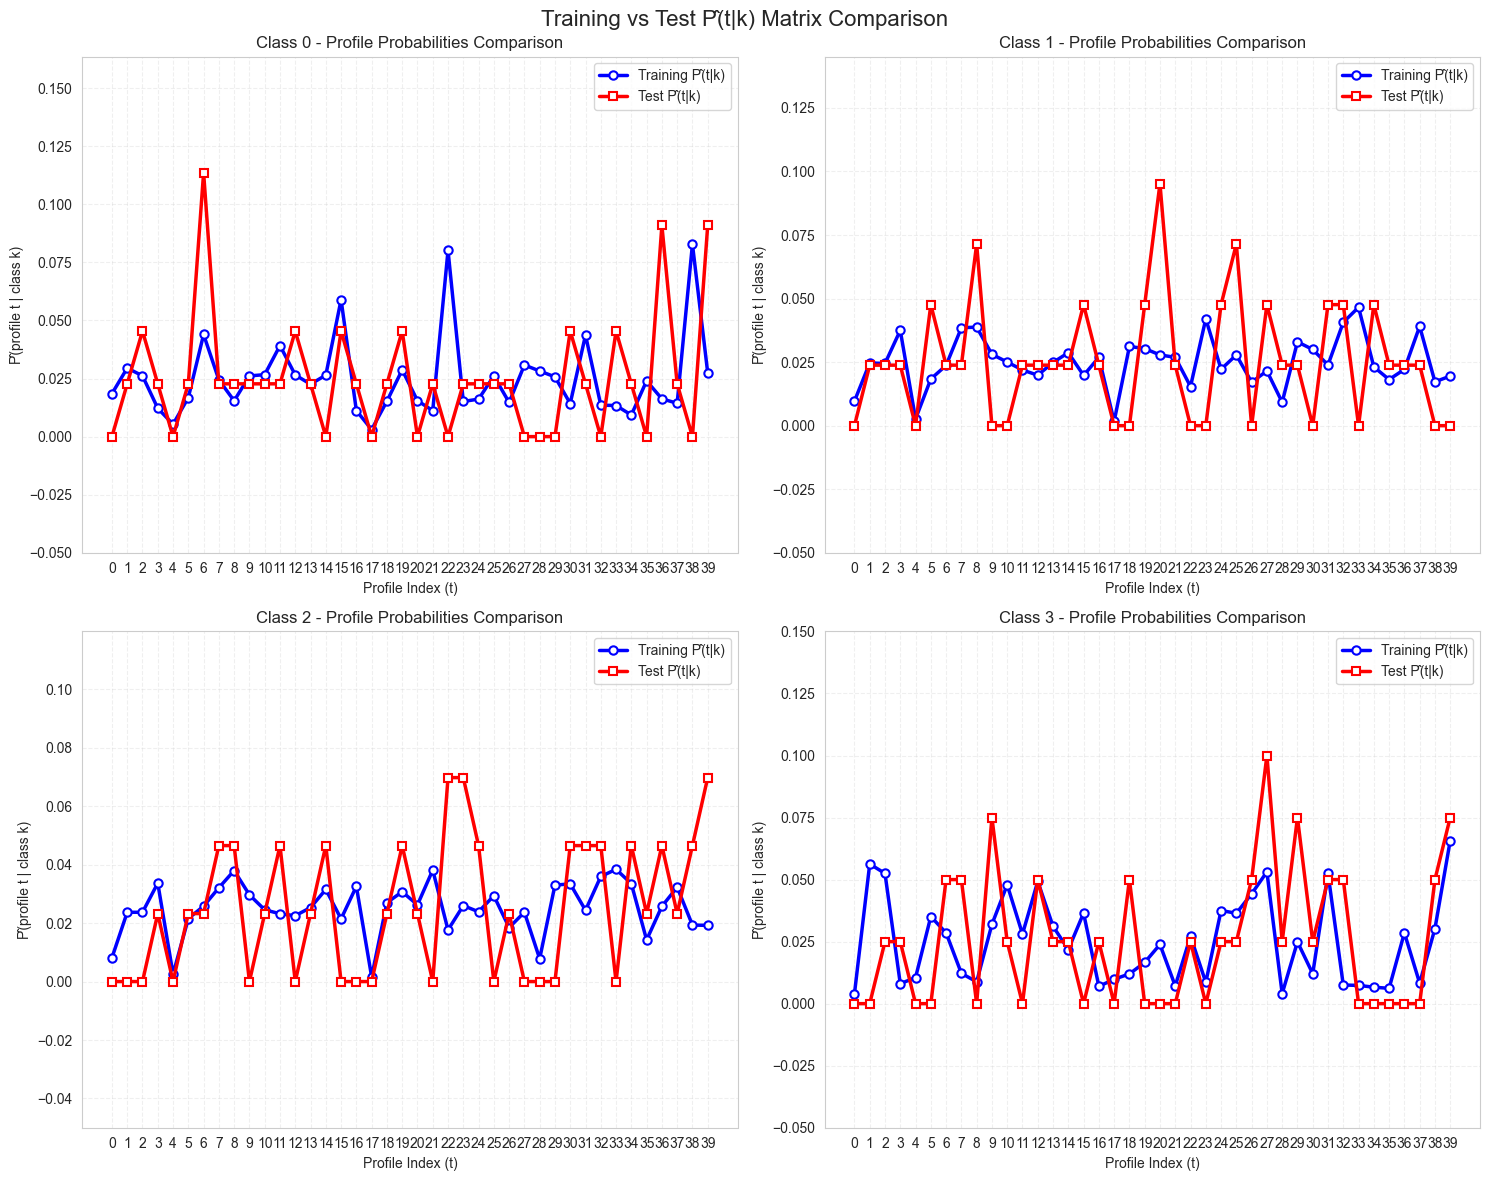

In [212]:
from dbc.utils import compute_pz_given_y
from dbc.utils import compute_p_hat_old_version
import skfuzzy as fuzz


import matplotlib.pyplot as plt
import numpy as np

# 计算预测的 p_hat
p_hat_pred = compute_p_hat_old_version(
            DMC.discretization_model.labels_,
            y_test,
            4,
            DMC.discretization_model.n_clusters,
        )

# 获取 SPDBC 的 p_hat（训练时的）
p_hat_train = SPDBC.p_hat

# 确保两个矩阵有相同的形状
n_classes, n_profiles = p_hat_train.shape
assert p_hat_pred.shape == p_hat_train.shape, "两个 p_hat 矩阵形状不匹配"

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 假设有4个类别
axes = axes.flatten()

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
markers = ['o', 's', '^', 'D', 'v', '<']

for k in range(n_classes):
    ax = axes[k]

    # 绘制训练集的 p_hat (SPDBC.p_hat)
    ax.plot(range(n_profiles), p_hat_train[k, :],
            color=colors[0], marker=markers[0],
            linewidth=2.5, markersize=6,
            label='Training P̂(t|k)',
            markerfacecolor='white',
            markeredgewidth=1.5)

    # 绘制测试集的 p_hat (预测的)
    ax.plot(range(n_profiles), p_hat_pred[k, :],
            color=colors[1], marker=markers[1],
            linewidth=2.5, markersize=6,
            label='Test P̂(t|k)',
            markerfacecolor='white',
            markeredgewidth=1.5)

    ax.set_title(f'Class {k} - Profile Probabilities Comparison', fontsize=12)
    ax.set_xlabel('Profile Index (t)', fontsize=10)
    ax.set_ylabel('P̂(profile t | class k)', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(range(n_profiles))

    # 设置y轴范围
    y_min = min(p_hat_train[k, :].min(), p_hat_pred[k, :].min()) - 0.05
    y_max = max(p_hat_train[k, :].max(), p_hat_pred[k, :].max()) + 0.05
    ax.set_ylim(y_min, y_max)

# 隐藏多余的子图（如果类别数少于4）
for k in range(n_classes, len(axes)):
    axes[k].set_visible(False)

plt.suptitle('Training vs Test P̂(t|k) Matrix Comparison', fontsize=16)
plt.tight_layout()
plt.show()

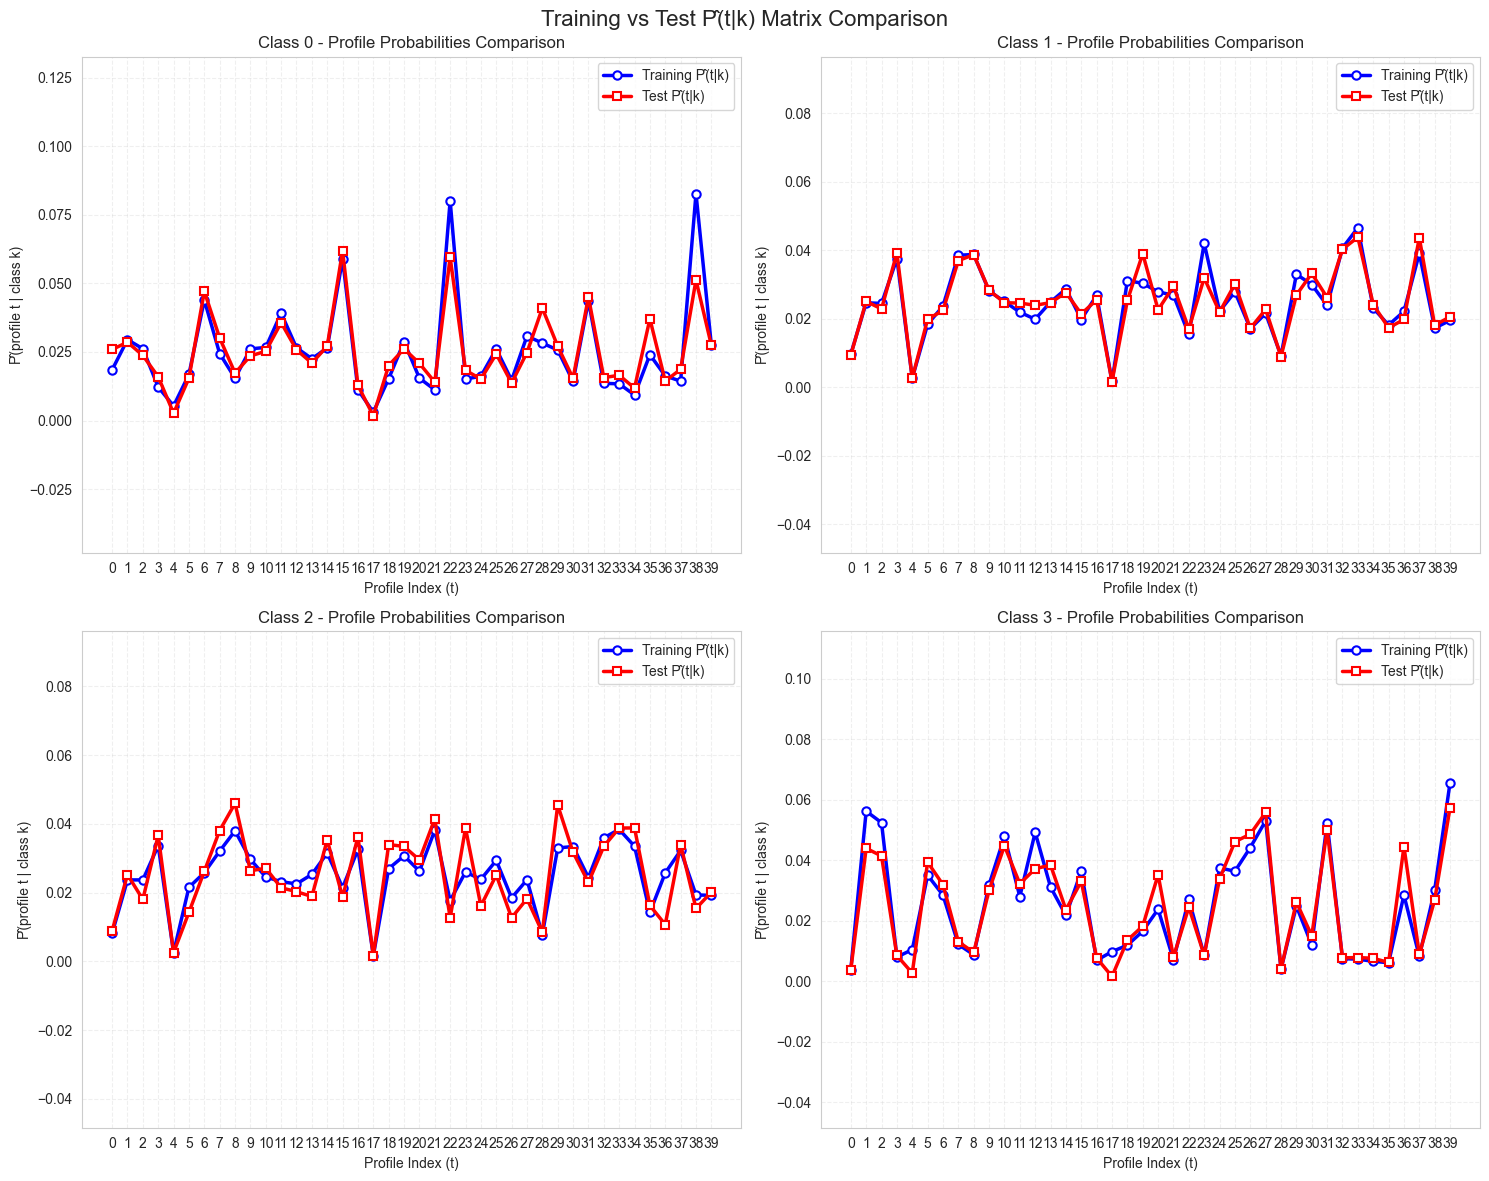

In [213]:
from dbc.utils import compute_pz_given_y

import skfuzzy as fuzz

pred_membership_degree, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
                X_test.T,
                cntr_trained=SPDBC.cluster_centers,
                m=SPDBC.fuzzifier,
                error=SPDBC.tol,
                maxiter=SPDBC.max_iter,
                metric=SPDBC.metric,
                init=SPDBC.init,
                seed=SPDBC.random_state,
            )

import matplotlib.pyplot as plt
import numpy as np

# 计算预测的 p_hat
p_hat_pred = compute_pz_given_y(pred_membership_degree, y_test, 4)

# 获取 SPDBC 的 p_hat（训练时的）
p_hat_train = SPDBC.p_hat

# 确保两个矩阵有相同的形状
n_classes, n_profiles = p_hat_train.shape
assert p_hat_pred.shape == p_hat_train.shape, "两个 p_hat 矩阵形状不匹配"

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 假设有4个类别
axes = axes.flatten()

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
markers = ['o', 's', '^', 'D', 'v', '<']

for k in range(n_classes):
    ax = axes[k]

    # 绘制训练集的 p_hat (SPDBC.p_hat)
    ax.plot(range(n_profiles), p_hat_train[k, :],
            color=colors[0], marker=markers[0],
            linewidth=2.5, markersize=6,
            label='Training P̂(t|k)',
            markerfacecolor='white',
            markeredgewidth=1.5)

    # 绘制测试集的 p_hat (预测的)
    ax.plot(range(n_profiles), p_hat_pred[k, :],
            color=colors[1], marker=markers[1],
            linewidth=2.5, markersize=6,
            label='Test P̂(t|k)',
            markerfacecolor='white',
            markeredgewidth=1.5)

    ax.set_title(f'Class {k} - Profile Probabilities Comparison', fontsize=12)
    ax.set_xlabel('Profile Index (t)', fontsize=10)
    ax.set_ylabel('P̂(profile t | class k)', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(range(n_profiles))

    # 设置y轴范围
    y_min = min(p_hat_train[k, :].min(), p_hat_pred[k, :].min()) - 0.05
    y_max = max(p_hat_train[k, :].max(), p_hat_pred[k, :].max()) + 0.05
    ax.set_ylim(y_min, y_max)

# 隐藏多余的子图（如果类别数少于4）
for k in range(n_classes, len(axes)):
    axes[k].set_visible(False)

plt.suptitle('Training vs Test P̂(t|k) Matrix Comparison', fontsize=16)
plt.tight_layout()
plt.show()